## 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np

import xgboost as xgb

import tensorflow as tf

import mimic_iv_utils as utils

from functools import reduce

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn import metrics

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras.models import Sequential
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from matplotlib import pyplot as plt

## 2. Fetch Data

In [3]:
duration_data = {}

durations = [8, 12, 16, 24, 48, 72, 96, 120, 144]

for d in tqdm(durations):
    static = utils.getStaticFeatures()
    first_lab = utils.getLabFeatures(duration=d)
    last_lab = utils.getLabFeatures(mode='last', duration=d)
    first_vitals = utils.getVitalsFeatures(duration=d)
    last_vitals = utils.getVitalsFeatures(mode='last', duration=d)
    max_vitals = utils.getMinMaxVitalsFeatures(mode='max', duration=d)
    min_vitals = utils.getMinMaxVitalsFeatures(duration=d)
    avg_vitals = utils.getMinMaxVitalsFeatures(mode='avg', duration=d)
    mortality = utils.getInhospitalMortality()
    filtered = utils.getFilteredCohort(duration=d)

    dfs = [filtered, static, first_lab, last_lab, first_vitals, last_vitals, max_vitals, min_vitals, avg_vitals, mortality]
    data = reduce(lambda  left, right: pd.merge(left, right, on=['stay_id'], how='inner'), dfs)

    data.drop(columns=['subject_id', 'hadm_id', 'stay_id'], inplace=True)

    X = data.values
    y = X[:,-1]
    y = y.astype('int')
    X = X[:,0:-1]
    X_header = [x for x in data.columns.values]
    X_header = X_header[0:-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    duration_data[d] = [X_train, X_test, y_train, y_test]

100%|██████████| 9/9 [39:30<00:00, 263.37s/it]


## 3. Deep Learning

In [4]:
results = {}
for k, v in tqdm(duration_data.items()):
    X_train, X_test, y_train, y_test = v[0], v[1], v[2], v[3]
    X_train_array = np.asarray(X_train).astype('float32')
    X_test_array = np.asarray(X_test).astype('float32')
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp_mean.fit(X_train_array)
    X_train_imputed = imp_mean.transform(X_train_array)
    X_test_imputed = imp_mean.transform(X_test_array)
    normalizer = preprocessing.Normalization()
    normalizer.adapt(X_train_imputed)
    X_train_noralized = normalizer(X_train_imputed)
    X_test_noralized = normalizer(X_test_imputed)

    model = Sequential()
    model.add(layers.Dense(X_train.shape[1], activation=tf.nn.relu, kernel_initializer='he_normal', bias_initializer='zeros'))
    model.add(layers.Dense(40, activation=tf.nn.relu, kernel_initializer='he_normal', bias_initializer='zeros'))
    model.add(layers.Dense(1, activation=tf.nn.sigmoid, kernel_initializer='he_normal', bias_initializer='zeros'))

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    model.fit(X_train_noralized, y_train, validation_data=(X_test_noralized, y_test), epochs=5, batch_size=256)

    probs = model.predict(X_test_noralized)

    results[k] = [y_test, probs]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5
212/212 [==============================] - 24s 4ms/step - loss: 0.3735 - accuracy: 0.8385 - val_loss: 0.2325 - val_accuracy: 0.9139
Epoch 2/5
212/212 [==============================] - 0s 2ms/step - loss: 0.2247 - accuracy: 0.9108 - val_loss: 0.2275 - val_accuracy: 0.9150
Epoch 3/5
212/212 [==============================] - 0s 2ms/step - loss: 0.2103 - accuracy: 0.9162 - val_loss: 0.2230 - val_accuracy: 0.9171
Epoch 4/5
212/212 [==============================] - 0s 2ms/step - loss: 0.2027 - accuracy: 0.9204 - val_loss: 0.2210 - val_accuracy: 0.9201
Epoch 5/5
212/212 [==============================] - 0s 2ms/step - loss: 0.1988 - accuracy: 0.9216 - val_loss: 0.2218 - val_accuracy: 0.9178


 11%|█         | 1/9 [00:29<03:58, 29.80s/it]

Epoch 1/5
208/208 [==============================] - 2s 3ms/step - loss: 0.2749 - accuracy: 0.9058 - val_loss: 0.2253 - val_accuracy: 0.9142
Epoch 2/5
208/208 [==============================] - 0s 2ms/step - loss: 0.2129 - accuracy: 0.9175 - val_loss: 0.2218 - val_accuracy: 0.9158
Epoch 3/5
208/208 [==============================] - 0s 2ms/step - loss: 0.1978 - accuracy: 0.9226 - val_loss: 0.2185 - val_accuracy: 0.9181
Epoch 4/5
208/208 [==============================] - 0s 2ms/step - loss: 0.1937 - accuracy: 0.9234 - val_loss: 0.2181 - val_accuracy: 0.9181
Epoch 5/5
208/208 [==============================] - 0s 2ms/step - loss: 0.1859 - accuracy: 0.9282 - val_loss: 0.2207 - val_accuracy: 0.9154


 22%|██▏       | 2/9 [00:35<01:50, 15.76s/it]

Epoch 1/5
200/200 [==============================] - 2s 3ms/step - loss: 0.3327 - accuracy: 0.8690 - val_loss: 0.2120 - val_accuracy: 0.9217
Epoch 2/5
200/200 [==============================] - 0s 2ms/step - loss: 0.2058 - accuracy: 0.9188 - val_loss: 0.2068 - val_accuracy: 0.9241
Epoch 3/5
200/200 [==============================] - 0s 2ms/step - loss: 0.2001 - accuracy: 0.9226 - val_loss: 0.2030 - val_accuracy: 0.9241
Epoch 4/5
200/200 [==============================] - 0s 2ms/step - loss: 0.1957 - accuracy: 0.9225 - val_loss: 0.2021 - val_accuracy: 0.9240
Epoch 5/5
200/200 [==============================] - 0s 2ms/step - loss: 0.1854 - accuracy: 0.9282 - val_loss: 0.3504 - val_accuracy: 0.9234


 33%|███▎      | 3/9 [00:41<01:07, 11.20s/it]

Epoch 1/5
171/171 [==============================] - 2s 3ms/step - loss: 0.3243 - accuracy: 0.8751 - val_loss: 0.2180 - val_accuracy: 0.9140
Epoch 2/5
171/171 [==============================] - 0s 2ms/step - loss: 0.2114 - accuracy: 0.9158 - val_loss: 0.2144 - val_accuracy: 0.9138
Epoch 3/5
171/171 [==============================] - 0s 2ms/step - loss: 0.2067 - accuracy: 0.9163 - val_loss: 0.2075 - val_accuracy: 0.9181
Epoch 4/5
171/171 [==============================] - 0s 2ms/step - loss: 0.1953 - accuracy: 0.9230 - val_loss: 0.2074 - val_accuracy: 0.9157
Epoch 5/5
171/171 [==============================] - 0s 2ms/step - loss: 0.1929 - accuracy: 0.9228 - val_loss: 0.2055 - val_accuracy: 0.9175


 44%|████▍     | 4/9 [00:46<00:43,  8.77s/it]

Epoch 1/5
103/103 [==============================] - 1s 4ms/step - loss: 0.3676 - accuracy: 0.8641 - val_loss: 0.3495 - val_accuracy: 0.8918
Epoch 2/5
103/103 [==============================] - 0s 2ms/step - loss: 0.2627 - accuracy: 0.8927 - val_loss: 0.2558 - val_accuracy: 0.8955
Epoch 3/5
103/103 [==============================] - 0s 2ms/step - loss: 0.2458 - accuracy: 0.8996 - val_loss: 0.3578 - val_accuracy: 0.8952
Epoch 4/5
103/103 [==============================] - 0s 2ms/step - loss: 0.2411 - accuracy: 0.9009 - val_loss: 0.2933 - val_accuracy: 0.8985
Epoch 5/5
103/103 [==============================] - 0s 2ms/step - loss: 0.2280 - accuracy: 0.9082 - val_loss: 0.3020 - val_accuracy: 0.8953


 56%|█████▌    | 5/9 [00:50<00:27,  6.90s/it]

Epoch 1/5
68/68 [==============================] - 1s 5ms/step - loss: 0.4890 - accuracy: 0.7727 - val_loss: 0.3259 - val_accuracy: 0.8649
Epoch 2/5
68/68 [==============================] - 0s 2ms/step - loss: 0.3120 - accuracy: 0.8702 - val_loss: 0.3104 - val_accuracy: 0.8675
Epoch 3/5
68/68 [==============================] - 0s 2ms/step - loss: 0.2961 - accuracy: 0.8780 - val_loss: 0.3056 - val_accuracy: 0.8682
Epoch 4/5
68/68 [==============================] - 0s 2ms/step - loss: 0.2730 - accuracy: 0.8834 - val_loss: 0.3032 - val_accuracy: 0.8698
Epoch 5/5
68/68 [==============================] - 0s 2ms/step - loss: 0.2613 - accuracy: 0.8915 - val_loss: 0.3034 - val_accuracy: 0.8680


 67%|██████▋   | 6/9 [00:52<00:16,  5.52s/it]

Epoch 1/5
48/48 [==============================] - 1s 7ms/step - loss: 0.5956 - accuracy: 0.6921 - val_loss: 0.3605 - val_accuracy: 0.8548
Epoch 2/5
48/48 [==============================] - 0s 2ms/step - loss: 0.3601 - accuracy: 0.8434 - val_loss: 0.3397 - val_accuracy: 0.8620
Epoch 3/5
48/48 [==============================] - 0s 2ms/step - loss: 0.3329 - accuracy: 0.8582 - val_loss: 0.3266 - val_accuracy: 0.8568
Epoch 4/5
48/48 [==============================] - 0s 2ms/step - loss: 0.3075 - accuracy: 0.8670 - val_loss: 0.3231 - val_accuracy: 0.8597
Epoch 5/5
48/48 [==============================] - 0s 2ms/step - loss: 0.3038 - accuracy: 0.8709 - val_loss: 0.3191 - val_accuracy: 0.8640


 78%|███████▊  | 7/9 [00:55<00:09,  4.50s/it]

Epoch 1/5
36/36 [==============================] - 2s 8ms/step - loss: 0.6384 - accuracy: 0.6676 - val_loss: 0.4361 - val_accuracy: 0.8093
Epoch 2/5
36/36 [==============================] - 0s 3ms/step - loss: 0.4045 - accuracy: 0.8209 - val_loss: 0.4099 - val_accuracy: 0.8202
Epoch 3/5
36/36 [==============================] - 0s 3ms/step - loss: 0.3559 - accuracy: 0.8448 - val_loss: 0.4002 - val_accuracy: 0.8246
Epoch 4/5
36/36 [==============================] - 0s 2ms/step - loss: 0.3382 - accuracy: 0.8528 - val_loss: 0.3983 - val_accuracy: 0.8241
Epoch 5/5
36/36 [==============================] - 0s 3ms/step - loss: 0.3222 - accuracy: 0.8594 - val_loss: 0.3971 - val_accuracy: 0.8315


 89%|████████▉ | 8/9 [00:57<00:03,  3.87s/it]

Epoch 1/5
29/29 [==============================] - 1s 10ms/step - loss: 0.6171 - accuracy: 0.6817 - val_loss: 0.5824 - val_accuracy: 0.8130
Epoch 2/5
29/29 [==============================] - 0s 3ms/step - loss: 0.4096 - accuracy: 0.8157 - val_loss: 0.5501 - val_accuracy: 0.8234
Epoch 3/5
29/29 [==============================] - 0s 3ms/step - loss: 0.3717 - accuracy: 0.8329 - val_loss: 0.4990 - val_accuracy: 0.8190
Epoch 4/5
29/29 [==============================] - 0s 3ms/step - loss: 0.3537 - accuracy: 0.8402 - val_loss: 0.4562 - val_accuracy: 0.8278
Epoch 5/5
29/29 [==============================] - 0s 3ms/step - loss: 0.3367 - accuracy: 0.8500 - val_loss: 0.4403 - val_accuracy: 0.8295


100%|██████████| 9/9 [00:59<00:00,  6.66s/it]


## 4. Results

  0%|          | 0/9 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------------------------------------
-------------------------------------------- * duration =8 * ----------------------------------------------------
--------------------------------------------------------------------------------------------------------------------
ROC:  0.8949449543461865
              precision    recall  f1-score   support

           0       0.93      0.98      0.96     12152
           1       0.67      0.37      0.48      1373

    accuracy                           0.92     13525
   macro avg       0.80      0.67      0.72     13525
weighted avg       0.91      0.92      0.91     13525



 11%|█         | 1/9 [00:00<00:01,  7.56it/s]

--------------------------------------------------------------------------------------------------------------------
-------------------------------------------- * duration =12 * ----------------------------------------------------
--------------------------------------------------------------------------------------------------------------------
ROC:  0.8949559020707714
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     11923
           1       0.63      0.38      0.47      1334

    accuracy                           0.92     13257
   macro avg       0.78      0.68      0.71     13257
weighted avg       0.90      0.92      0.91     13257



 22%|██▏       | 2/9 [00:00<00:00,  8.08it/s]

--------------------------------------------------------------------------------------------------------------------
-------------------------------------------- * duration =16 * ----------------------------------------------------
--------------------------------------------------------------------------------------------------------------------
ROC:  0.9090377889236363
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     11506
           1       0.70      0.37      0.49      1241

    accuracy                           0.92     12747
   macro avg       0.82      0.68      0.72     12747
weighted avg       0.91      0.92      0.91     12747



 33%|███▎      | 3/9 [00:00<00:00,  8.29it/s]

--------------------------------------------------------------------------------------------------------------------
-------------------------------------------- * duration =24 * ----------------------------------------------------
--------------------------------------------------------------------------------------------------------------------
ROC:  0.9059128285958933
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      9816
           1       0.65      0.39      0.49      1106

    accuracy                           0.92     10922
   macro avg       0.79      0.68      0.72     10922
weighted avg       0.91      0.92      0.91     10922



 44%|████▍     | 4/9 [00:00<00:00,  8.75it/s]

--------------------------------------------------------------------------------------------------------------------
-------------------------------------------- * duration =48 * ----------------------------------------------------
--------------------------------------------------------------------------------------------------------------------
ROC:  0.8915834463273924
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      5725
           1       0.64      0.43      0.51       847

    accuracy                           0.90      6572
   macro avg       0.78      0.70      0.73      6572
weighted avg       0.88      0.90      0.89      6572

--------------------------------------------------------------------------------------------------------------------
-------------------------------------------- * duration =72 * ----------------------------------------------------
-------------------------------------------------------------------

 67%|██████▋   | 6/9 [00:00<00:00, 10.69it/s]

--------------------------------------------------------------------------------------------------------------------
-------------------------------------------- * duration =96 * ----------------------------------------------------
--------------------------------------------------------------------------------------------------------------------
ROC:  0.8806813233124956
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      2476
           1       0.68      0.52      0.59       575

    accuracy                           0.86      3051
   macro avg       0.79      0.73      0.75      3051
weighted avg       0.85      0.86      0.86      3051



100%|██████████| 9/9 [00:00<00:00, 11.27it/s]


--------------------------------------------------------------------------------------------------------------------
-------------------------------------------- * duration =120 * ----------------------------------------------------
--------------------------------------------------------------------------------------------------------------------
ROC:  0.8264672457649676
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1823
           1       0.65      0.40      0.50       474

    accuracy                           0.83      2297
   macro avg       0.75      0.67      0.70      2297
weighted avg       0.82      0.83      0.82      2297

--------------------------------------------------------------------------------------------------------------------
-------------------------------------------- * duration =144 * ----------------------------------------------------
-----------------------------------------------------------------

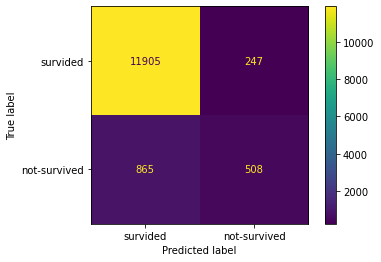

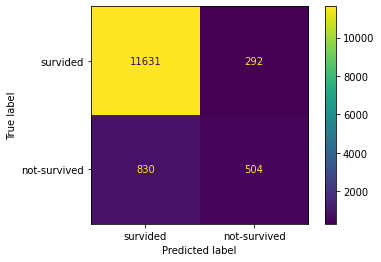

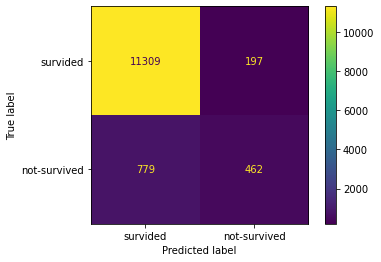

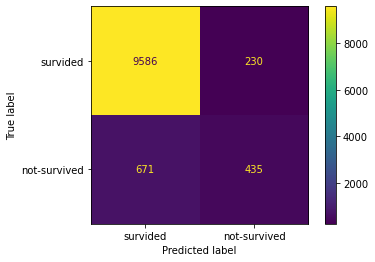

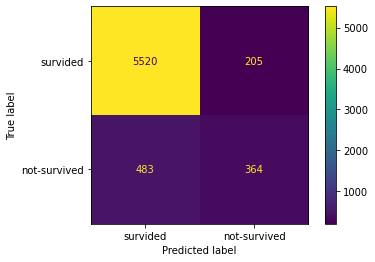

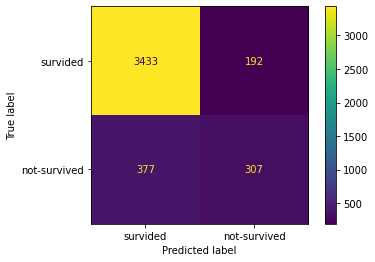

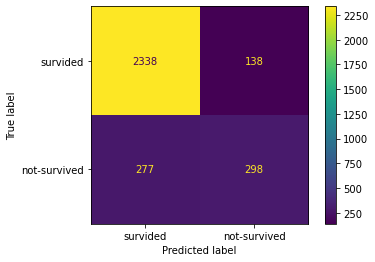

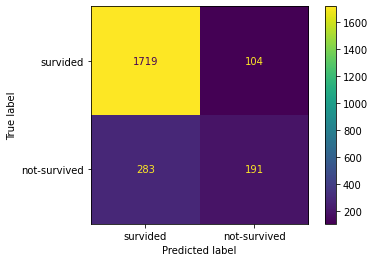

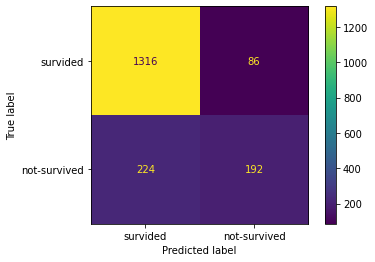

In [5]:
for k, v in tqdm(results.items()):
    y_test = v[0]
    probs = v[1]
    preds = np.around(probs)

    print('--------------------------------------------------------------------------------------------------------------------')
    print('-------------------------------------------- * duration ='+ str(k)+' * ----------------------------------------------------')
    print('--------------------------------------------------------------------------------------------------------------------')
    roc_score = metrics.roc_auc_score(y_test, probs)
    
    print('ROC: ', roc_score)

    classification_report = metrics.classification_report(y_test, preds)
    print(classification_report)

    cm = confusion_matrix(y_test, preds, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['survided', 'not-survived'])
    disp.plot()

100%|██████████| 9/9 [00:00<00:00, 310.24it/s]


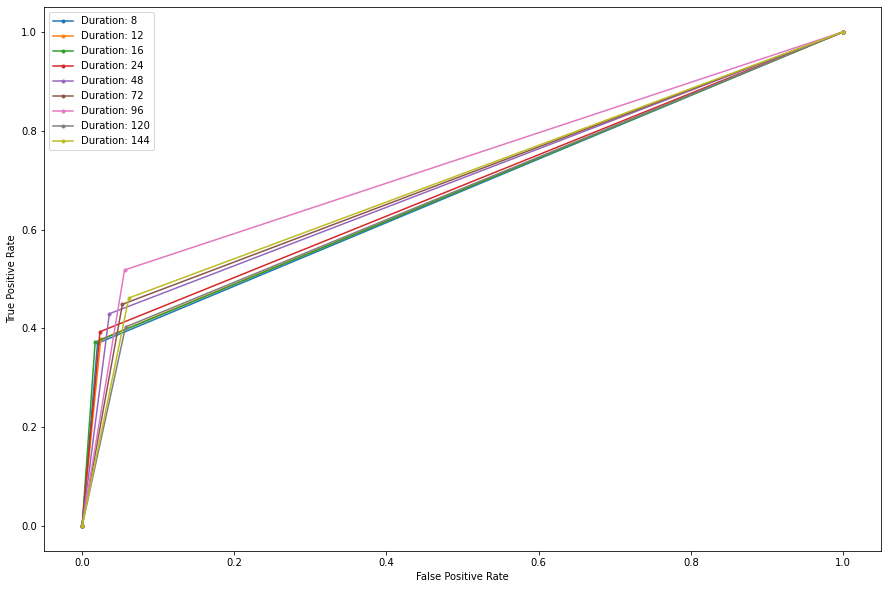

In [6]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(15,10))

for k, v in tqdm(results.items()):
    y_test = v[0]
    probs = v[1]
    preds = np.around(probs)

    fpr, tpr, _ = roc_curve(y_test, preds)
    plt.plot(fpr, tpr, marker='.', label='Duration: ' + str(k))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]/superbugai-data/yash/chapter_1/workspace/MIMIC_Extract/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
 11%|█         | 1/9 [00:00<00:03,  2.35it/s]/superbugai-data/yash/chapter_1/workspace/MIMIC_Extract/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/superbugai-data/yash/chapter_1/workspace/MIMIC_Extract/.venv/lib/python3.9/site-packages/seaborn/distributions.py

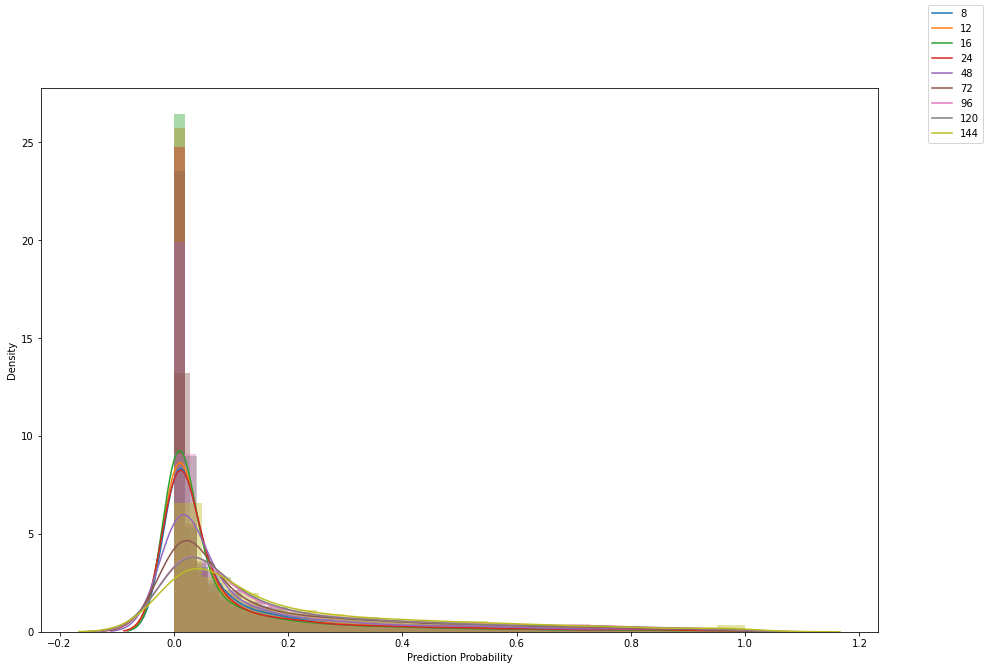

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,10))
for k, v in tqdm(results.items()):
    y_test = v[0]
    probs = v[1]
    sns.distplot(probs, hist=True, rug=False, axlabel='Prediction Probability')
fig.legend(labels=results.keys())
plt.show()